In [1]:
!pip install torch
!pip install torchvision

In [2]:
# Import PyTorch modules needed
import torch
import os
import numpy as np
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from torch import nn, optim
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
from sklearn.metrics import accuracy_score
torch.manual_seed(0)

In [3]:
torch.cuda.is_available()
device = torch.device('cuda:0')

In [4]:
# Transformations to be applied to data (pre-processing)
composed = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [5]:
# Paths to google drive for acquiring dataset.
from google.colab import drive
drive.mount('/content/drive')

data_dir = '/content/drive/MyDrive/archive/FishImgDataset'
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Load the training, validation and test datasets.
train_dataset = datasets.ImageFolder(root=train_dir, transform=composed)
val_dataset = datasets.ImageFolder(root=val_dir, transform=composed)
test_dataset = datasets.ImageFolder(root=test_dir, transform=composed)

In [7]:
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=16, shuffle=False)

In [8]:
for x, y in train_loader:
    print(x.shape, y.shape)
    break

torch.Size([16, 3, 128, 128]) torch.Size([16])


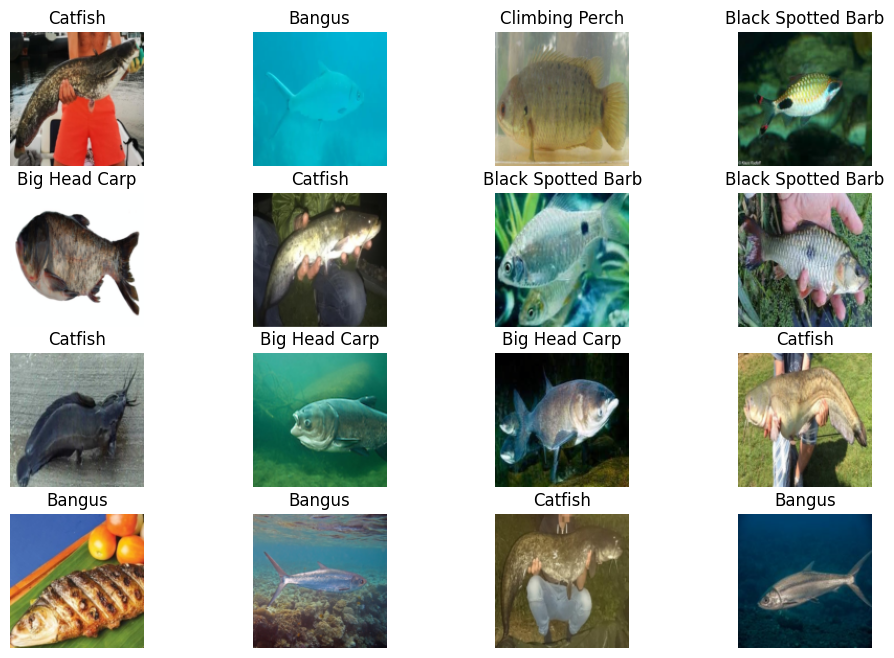

In [9]:
def show_images(images, labels, classes):
    plt.figure(figsize=(12, 8))
    for i in range(len(images)):
        plt.subplot(4, 4, i + 1)
        img = images[i].cpu().clone()
        img = img.numpy().transpose(1, 2, 0)
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.title(classes[labels[i]])
        plt.axis('off')
    plt.show()

for x_batch, y_batch in train_loader:
    classes = train_dataset.classes
    show_images(x_batch, y_batch, classes)
    break

In [10]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(train_dataset.classes))
model = model.to(device)

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001)

In [12]:
# Training and validation function

def train_and_validate_model(model, criterion, optimizer, train_loader, val_loader):
    model.train()
    num_epochs = 25
    for epoch in range(num_epochs):
        running_loss = 0.0
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            prediction = model(x)
            loss = criterion(prediction, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * x.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)

        model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val = x_val.to(device)
                y_val = y_val.to(device)
                prediction = model(x_val)
                _, preds = torch.max(prediction, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(y_val.cpu().numpy())

        val_accuracy = accuracy_score(all_labels, all_preds)

        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
train_and_validate_model(model, criterion, optimizer, train_loader, val_loader)

Epoch 1/25, Loss: 1.6623, Validation Accuracy: 0.3220
Epoch 2/25, Loss: 1.4881, Validation Accuracy: 0.4489
Epoch 3/25, Loss: 1.3111, Validation Accuracy: 0.5480
Epoch 4/25, Loss: 1.1599, Validation Accuracy: 0.6285
Epoch 5/25, Loss: 1.0256, Validation Accuracy: 0.6749
Epoch 6/25, Loss: 0.9043, Validation Accuracy: 0.7059
Epoch 7/25, Loss: 0.7938, Validation Accuracy: 0.7585
Epoch 8/25, Loss: 0.6950, Validation Accuracy: 0.8142
Epoch 9/25, Loss: 0.6081, Validation Accuracy: 0.8452
Epoch 10/25, Loss: 0.5339, Validation Accuracy: 0.8700
Epoch 11/25, Loss: 0.4685, Validation Accuracy: 0.8978
Epoch 12/25, Loss: 0.4123, Validation Accuracy: 0.9009
Epoch 13/25, Loss: 0.3657, Validation Accuracy: 0.9195
Epoch 14/25, Loss: 0.3252, Validation Accuracy: 0.9257
Epoch 15/25, Loss: 0.2895, Validation Accuracy: 0.9319
Epoch 16/25, Loss: 0.2581, Validation Accuracy: 0.9443
Epoch 17/25, Loss: 0.2304, Validation Accuracy: 0.9474
Epoch 18/25, Loss: 0.2066, Validation Accuracy: 0.9598
Epoch 19/25, Loss: 

In [13]:
# Test function

def test_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for x_test, y_test in test_loader:
            x_test = x_test.to(device)
            y_test = y_test.to(device)
            prediction = model(x_test)
            _, preds = torch.max(prediction, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_test.cpu().numpy())

    test_accuracy = accuracy_score(all_labels, all_preds)
    print(f'Test Accuracy: {test_accuracy:.4f}')
test_model(model, test_loader)

Test Accuracy: 0.9665
